In [153]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as c
import rebound
import seaborn as sns
from matplotlib import rcParams

sol_to_earth = 332946.078
AU = 1.496e+13 #cm
M_sun = 1.989e+33 #g
G = 6.6743* 10**(-8) #cm^-3.g^-1.s^-2

r_emb_chambers = 2.39e-5 * AU #cm, radius of embryo
r_pl_chambers = 1.11e-5 * AU #cm, radius of planetesimal

In [154]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

colors = [
    "#0072B2",  # Blue
    "#009E73",  # Green
    "#D55E00",  # Vermilion (reddish-orange)
    "#CC79A7",  # Reddish purple
    "#F0E442",  # Yellow
    "#56B4E9",  # Light blue
    "#E69F00",  # Orange
    "#000000",  # Black
]

In [155]:
def get_vesc(mt, mp, rt, rp):
    vesc = np.sqrt(2 * G * (mt + mp) / (rt + rp))
    return vesc

def get_vimp(vt, vp, mt, mp, rt, rp, xt, xp):
    vrel = np.sqrt( (vt[0] - vp[0])**2 + (vt[1] - vp[1])**2 + (vt[2] - vp[2])**2 )
    xrel = np.sqrt( (xt[0] - xp[0])**2 + (xt[1] - xp[1])**2 + (xt[2] - xp[2])**2 )
    rtot = rt + rp
    mtot = mt + mp
    vimp = np.sqrt(vrel**2 + 2 * G * mtot * (1/rtot - 1/xrel))
    return vimp

def get_vimp_vesc(mt, mp, rt, rp, d):
    v1 = np.sqrt((G*M_sun)/(d *(AU))) #cm/s
    vesc = np.sqrt(2 * G * (mt + mp) / (rt + rp))
    return v1/vesc

def get_vk(d):
    return np.sqrt(G*M_sun/(d * AU)) #cm/s

def get_vi_hyodo(e, i, vk, vesc):
    vran = np.sqrt(e**2 + i**2) * vk
    vimp = np.sqrt(vesc**2 + vran**2)
    return vimp

def get_r_from_rho(m, rho):
    v = m/rho
    r = ((3/(4*np.pi)) * v)**(1/3)
    return r

In [156]:
mt1 = 2.8e-7 * M_sun #grams, mass of embryo
mt2 = 2.8e-8 * M_sun #grams, mass of planetesimal
mt3 = 2.8e-9 * M_sun #grams

mp = np.logspace(-12, -7, 1000) * M_sun
rps = get_r_from_rho(mp, 3)
rt1 = get_r_from_rho(mt1, 3)
rt2 = get_r_from_rho(mt2, 3)
rt3 = get_r_from_rho(mt3, 3)

e = 0.2
i = 0

vi1 = get_vi_hyodo(e, i, get_vk(0.35), get_vesc(mt1, mp, rt1, rps))
vesc1 = get_vesc(mt1, mp, rt1, rps)
vi_vesc1 = vi1/vesc1

vi2 = get_vi_hyodo(e, i, get_vk(0.35), get_vesc(mt2, mp, rt2, rps))
vesc2 = get_vesc(mt2, mp, rt2, rps)
vi_vesc2 = vi2/vesc2

vi3 = get_vi_hyodo(e, i, get_vk(0.35), get_vesc(mt3, mp, rt3, rps))
vesc3 = get_vesc(mt3, mp, rt3, rps)
vi_vesc3 = vi3/vesc3

vi4 = np.linspace(10*1e5, 40*1e5, 1000)
vesc4 = get_vesc(mt1, mp, rt1, rps)
vi_vesc4 = vi4/vesc4

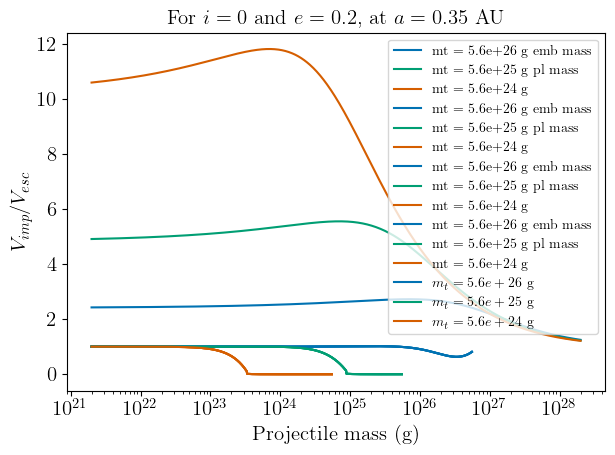

In [157]:
# Target masses in grams
mt_values = [2.8e-7, 2.8e-8, 2.8e-9]  # in M_sun units

# Projectile masses
mp = np.logspace(-12, -5, 1000) * M_sun
rps = get_r_from_rho(mp, 3)

e = 0.2
i = 0
a = 0.35  # AU

for mt_factor, color in zip(mt_values, colors):
    mt = mt_factor * M_sun
    rt = get_r_from_rho(mt, 3)
    vesc = get_vesc(mt, mp, rt, rps)
    vi = get_vi_hyodo(e, i, get_vk(a), vesc)
    vi_vesc = vi / vesc
    plt.plot(mp, vi_vesc, color=color, label=f'$m_t = {mt:.1e}$ g')

plt.title("For $i = 0$ and $e = 0.2$, at $a = 0.35$ AU")
plt.xlabel("Projectile mass (g)")
plt.ylabel("$V_{imp}/V_{esc}$")
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [158]:
m_test = 2.8e-7 * u.M_sun

m_test.to(u.M_earth)



<Quantity 0.0932249 earthMass>

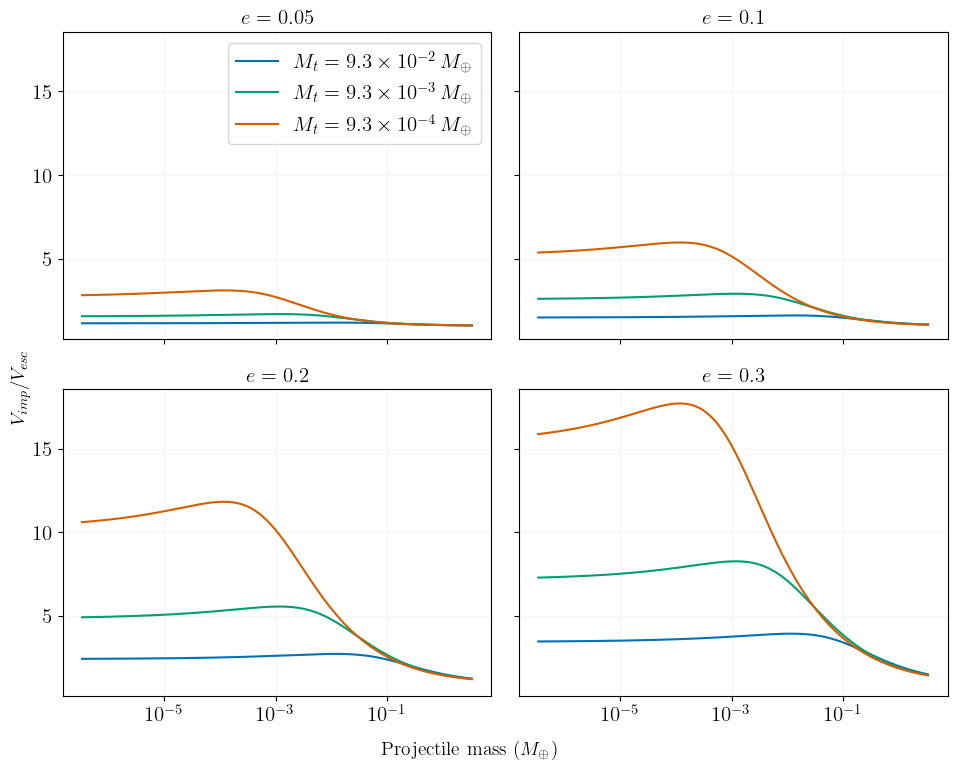

In [159]:
# Define projectile mass and radius

rps = get_r_from_rho(mp, 3)

# Target properties
mt_values = [2.8e-7, 2.8e-8, 2.8e-9]
#mt_values_to_plot = [2.8e-7, 2.8e-8, 2.8e-9] * u.M_sun # in M_sun
#mt_earth_mass = mt_values.to(u.M_earth).value


# Orbital parameters
i = 0
a = 0.35  # AU

# Eccentricities to plot
eccs = [0.05, 0.1, 0.2, 0.3]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for idx, (ax, e) in enumerate(zip(axes.flat, eccs)):
    for mt_factor, color in zip(mt_values, colors):
        mt = mt_factor * M_sun
        mt_label_val = (mt_factor * u.M_sun).to(u.M_earth).value

        # Scientific notation for target mass
        mt_label_str = f"{mt_label_val:.1e}"
        base, exp = mt_label_str.split('e')
        exp = int(exp)
        mt_label_str = rf"{float(base)} \times 10^{{{exp}}}"

        rt = get_r_from_rho(mt, 3)
        vesc = get_vesc(mt, mp, rt, rps)
        vi = get_vi_hyodo(e, i, get_vk(a), vesc)
        vi_vesc = vi / vesc
        mp_plot = mp * u.g.to(u.M_earth)

        ax.plot(mp_plot, vi_vesc, color=color,
                label=rf"$M_t = {mt_label_str}\,M_\oplus$")

    ax.grid(True, alpha=0.1)
    ax.set_xscale('log')
    ax.set_title(f"$e = {e}$")

    if idx == 0:
        ax.legend(fontsize=15)

# One shared label across the entire bottom
fig.text(0.5, 0.04, r"Projectile mass ($M_{\oplus}$)", ha='center', fontsize=14)

# One shared label along the entire left
fig.text(0.04, 0.5, r"$V_{imp}/V_{esc}$", va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.04, 0.05, 1, 1])


plt.savefig("paper_plots/vimp_changing_e.pdf", dpi=300)
plt.show()


In [160]:
def get_particle_params(base_path, runs, simarchive_name, time):
    """
    Extracts planetary parameters from simulation archives.

    Parameters:
    - base_path (str): Base path for simulation directories.
    - runs (list): List of run indices.

    Returns:
    - List of pandas DataFrames, each containing columns: ['semi', 'mass', 'radius', 'ecc', 'hash']
    """
    dataframes = []  # List to store DataFrames

    for i in runs:
        simarchive_dir = base_path +f"{i+1}"+"/"+simarchive_name+f"{i+1}" #sim archive directory 
        sa = rebound.Simulationarchive(simarchive_dir)
        snapshot = int(time/1e5)
        sim_f = sa[snapshot]  # Final snapshot
        n_bodies = sim_f.N - 3  # Exclude Sun, Jupiter, Saturn

    
        # Collect data for this run
        planet_data = {"semi": [], "mass": [], "radius": [], "ecc": [], "hash": [], "inc":[]}

        for j in range(n_bodies):
            a = sim_f.particles[j+1].a
            m = sim_f.particles[j+1].m
            r = sim_f.particles[j+1].r
            e = sim_f.particles[j+1].e
            h = sim_f.particles[j+1].hash.value  
            i = sim_f.particles[j+1].inc

            if 0 <= a < 100:  # Filter valid semi-major axes
                planet_data["semi"].append(a)
                planet_data["mass"].append(m)
                planet_data["radius"].append(r)
                planet_data["ecc"].append(e)
                planet_data["hash"].append(h)
                planet_data["inc"].append(i)

        # Convert to DataFrame and store
        df = pd.DataFrame(planet_data)
        dataframes.append(df)

    return dataframes  # List of DataFrames

def read_dbct_output(filename, total_cmf, boundary, percentage):
    df = pd.DataFrame(columns=['hash', 'mass', 'cmf'])

    data = np.loadtxt(filename)
    df['hash'] = data[:,0]
    df['mass'] = data[:,1]
    df['cmf'] = data[:,2]
    df['tot_disk_cmf'] = total_cmf
    df['boundary'] = boundary
    df['percentage'] = percentage

    return df

In [161]:
pp_list_1 = get_particle_params(f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", range(30), "cham_simarchive_", 1e5)
pp1 = pd.concat(pp_list_1)
pp_list_2 = get_particle_params(f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", range(30), "cham_simarchive_", 1e6)
pp2 = pd.concat(pp_list_2)
pp_list_3 = get_particle_params(f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", range(30), "cham_simarchive_", 1e7)
pp3 = pd.concat(pp_list_3)

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [162]:
pp_list_4 = []

for i in range(30):
    try:
        result = get_particle_params(
            f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", 
            [i], 
            "cham_simarchive_", 
            1e8
        )
        pp_list_4.append(result[0])  # if result is a list, unpack it
    except Exception as e:
        print(f"Skipped run {i}: {e}")

pp4 = pd.concat(pp_list_4)

Skipped run 20: Index out of range, number of snapshots stored in binary: 611.
Skipped run 22: Index out of range, number of snapshots stored in binary: 395.


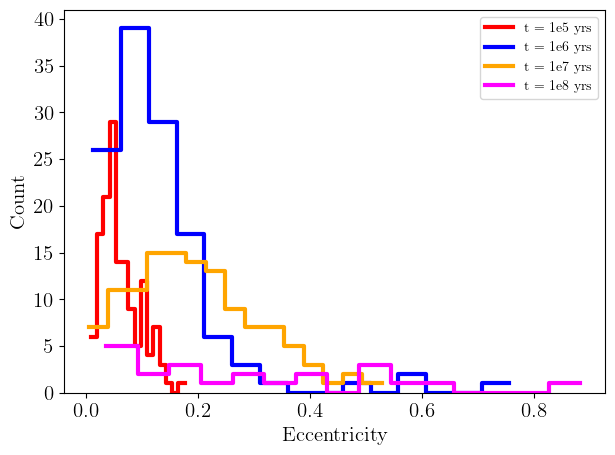

In [163]:
# Histogram plots
sns.histplot(pp_list_1[0]['ecc'], element='step', fill=False, lw=3, linestyle='-', bins=15, label='t = 1e5 yrs', color = 'red')
sns.histplot(pp_list_2[0]['ecc'], element='step', fill=False, lw=3, linestyle='-', bins=15, label='t = 1e6 yrs', color = 'blue')
sns.histplot(pp_list_3[0]['ecc'], element='step', fill=False, lw=3, linestyle='-', bins=15, label='t = 1e7 yrs', color = 'orange')
sns.histplot(pp_list_4[0]['ecc'], element='step', fill=False, lw=3, linestyle='-', bins=15, label='t = 1e8 yrs', color = 'magenta')

plt.xlabel("Eccentricity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.show()

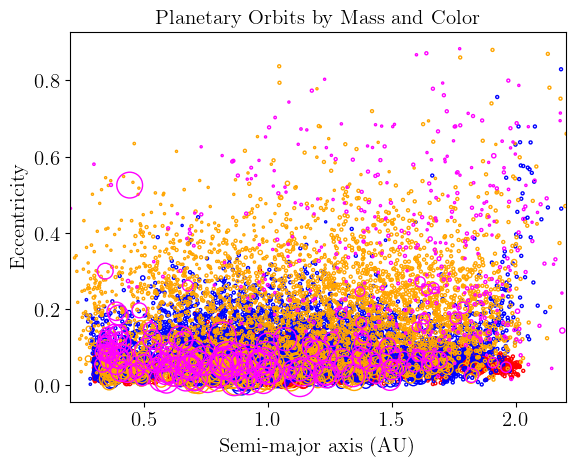

In [164]:
plt.scatter(pp1['semi'], pp1['ecc'], s=pp1['mass'] * sol_to_earth * 500, facecolors='none', edgecolors='red')
plt.scatter(pp2['semi'], pp2['ecc'], s=pp2['mass'] * sol_to_earth * 500, facecolors='none', edgecolors='blue')
plt.scatter(pp3['semi'], pp3['ecc'], s=pp3['mass'] * sol_to_earth * 500, facecolors='none', edgecolors='orange')
plt.scatter(pp4['semi'], pp4['ecc'], s=pp4['mass'] * sol_to_earth * 500, facecolors='none', edgecolors='magenta')

plt.xlim(0.2, 2.2)
plt.xlabel("Semi-major axis (AU)")
plt.ylabel("Eccentricity")
plt.title("Planetary Orbits by Mass and Color")
plt.show()

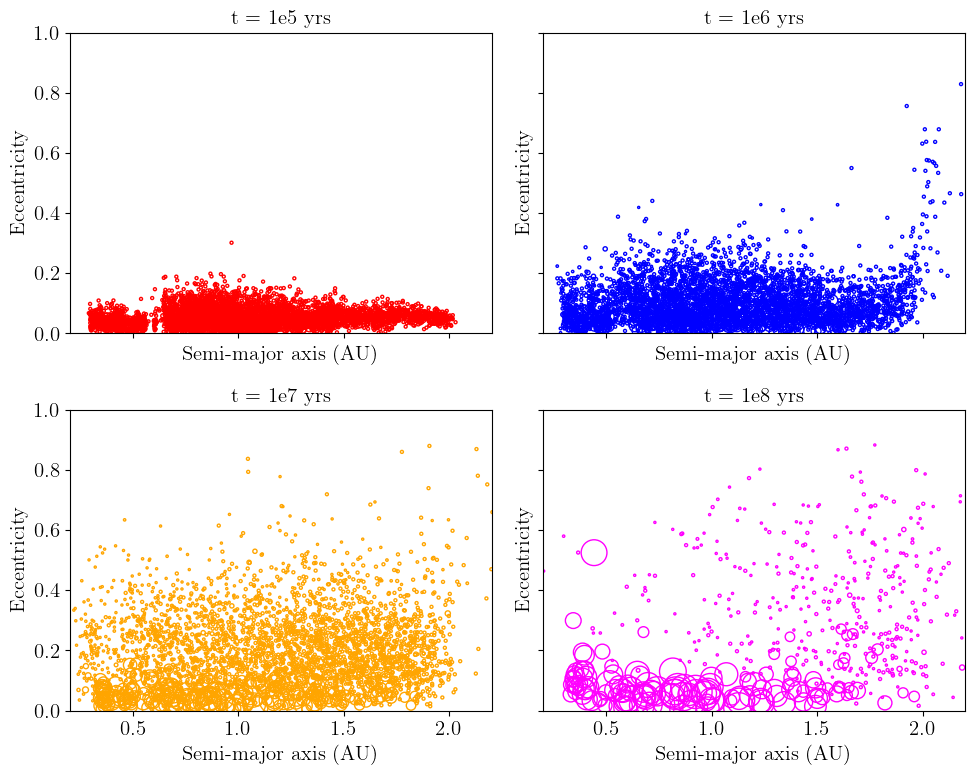

In [165]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Define a list of datasets and their properties
datasets = [
    (pp1, 'red', 't = 1e5 yrs'),
    (pp2, 'blue', 't = 1e6 yrs'),
    (pp3, 'orange', 't = 1e7 yrs'),
    (pp4, 'magenta', 't = 1e8 yrs')
]

for ax, (pp, color, title) in zip(axes.flat, datasets):
    ax.scatter(pp['semi'], pp['ecc'], 
               s=pp['mass'] * sol_to_earth * 500, 
               facecolors='none', 
               edgecolors=color)
    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("Semi-major axis (AU)")
    ax.set_ylabel("Eccentricity")

plt.tight_layout()
plt.show()


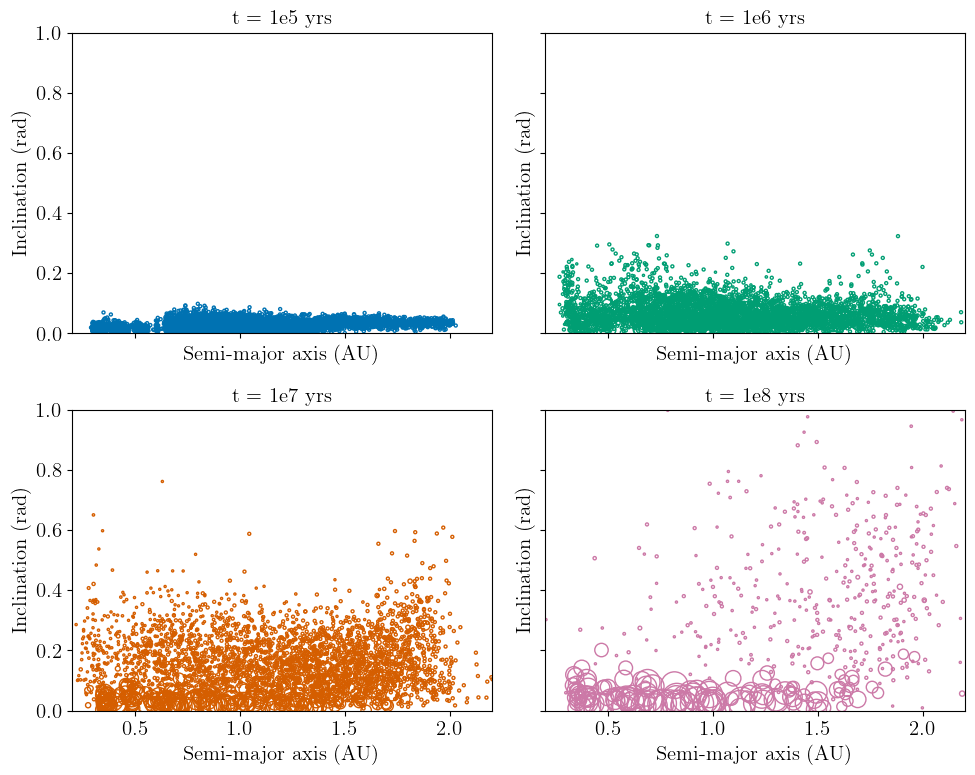

In [166]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Dataset: (data, edge color, subplot title)
datasets = [
    (pp1, colors[0], 't = 1e5 yrs'),
    (pp2, colors[1], 't = 1e6 yrs'),
    (pp3, colors[2], 't = 1e7 yrs'),
    (pp4, colors[3], 't = 1e8 yrs')
]

for ax, (pp, color, title) in zip(axes.flat, datasets):
    ax.scatter(pp['semi'], pp['inc'], 
               s=pp['mass'] * sol_to_earth * 500, 
               facecolors='none', 
               edgecolors=color)
    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(0, 1)  # You can adjust this limit based on your data
    ax.set_title(title)
    ax.set_xlabel("Semi-major axis (AU)")
    ax.set_ylabel("Inclination (rad)")

plt.tight_layout()
plt.show()


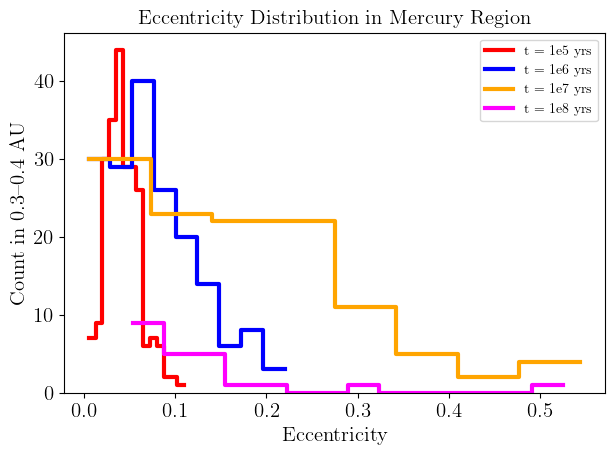

In [167]:
# Filter for Mercury region (0.3 < semi < 0.4 AU)
pp_merc_area_1 = pp1[(pp1['semi'] >= 0.3) & (pp1['semi'] <= 0.4)]
pp_merc_area_2 = pp2[(pp2['semi'] >= 0.3) & (pp2['semi'] <= 0.4)]
pp_merc_area_3 = pp3[(pp3['semi'] >= 0.3) & (pp3['semi'] <= 0.4)]
pp_merc_area_4 = pp4[(pp4['semi'] >= 0.3) & (pp4['semi'] <= 0.4)]

# Plot histograms of eccentricity for Mercury region
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(pp_merc_area_1['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e5 yrs', color='red')
sns.histplot(pp_merc_area_2['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e6 yrs', color='blue')
sns.histplot(pp_merc_area_3['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e7 yrs', color='orange')
sns.histplot(pp_merc_area_4['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e8 yrs', color='magenta')

plt.xlabel("Eccentricity")
plt.ylabel("Count in 0.3–0.4 AU")
plt.title("Eccentricity Distribution in Mercury Region")
plt.legend()
plt.tight_layout()
plt.show()


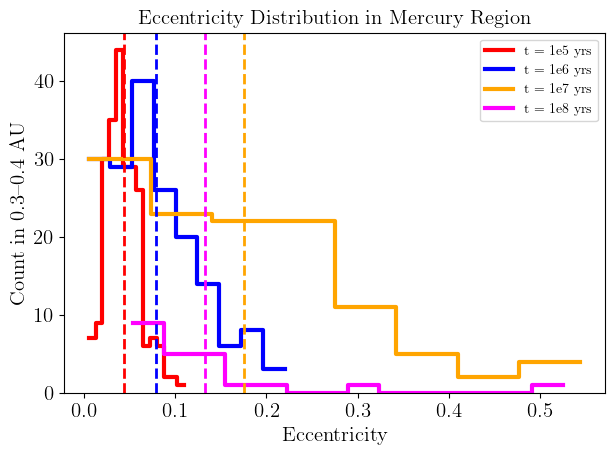

In [168]:
sns.histplot(pp_merc_area_1['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e5 yrs', color='red')
sns.histplot(pp_merc_area_2['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e6 yrs', color='blue')
sns.histplot(pp_merc_area_3['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e7 yrs', color='orange')
sns.histplot(pp_merc_area_4['ecc'], element='step', fill=False, lw=3, linestyle='-', label='t = 1e8 yrs', color='magenta')

# Calculate and plot mean eccentricity lines
means = [
    (pp_merc_area_1['ecc'].mean(), 'red'),
    (pp_merc_area_2['ecc'].mean(), 'blue'),
    (pp_merc_area_3['ecc'].mean(), 'orange'),
    (pp_merc_area_4['ecc'].mean(), 'magenta')
]

for mean_val, color in means:
    plt.axvline(mean_val, color=color, linestyle='--', lw=2)

plt.xlabel("Eccentricity")
plt.ylabel("Count in 0.3–0.4 AU")
plt.title("Eccentricity Distribution in Mercury Region")
plt.legend()
plt.tight_layout()
plt.show()


Mean eccentricity values:
t = 1e5 yrs: 0.0433
t = 1e6 yrs: 0.0788
t = 1e7 yrs: 0.1758
t = 1e8 yrs: 0.1323

Mean inclination values (radians):
t = 1e5 yrs: 0.0188
t = 1e6 yrs: 0.0807
t = 1e7 yrs: 0.1614
t = 1e8 yrs: 0.0704


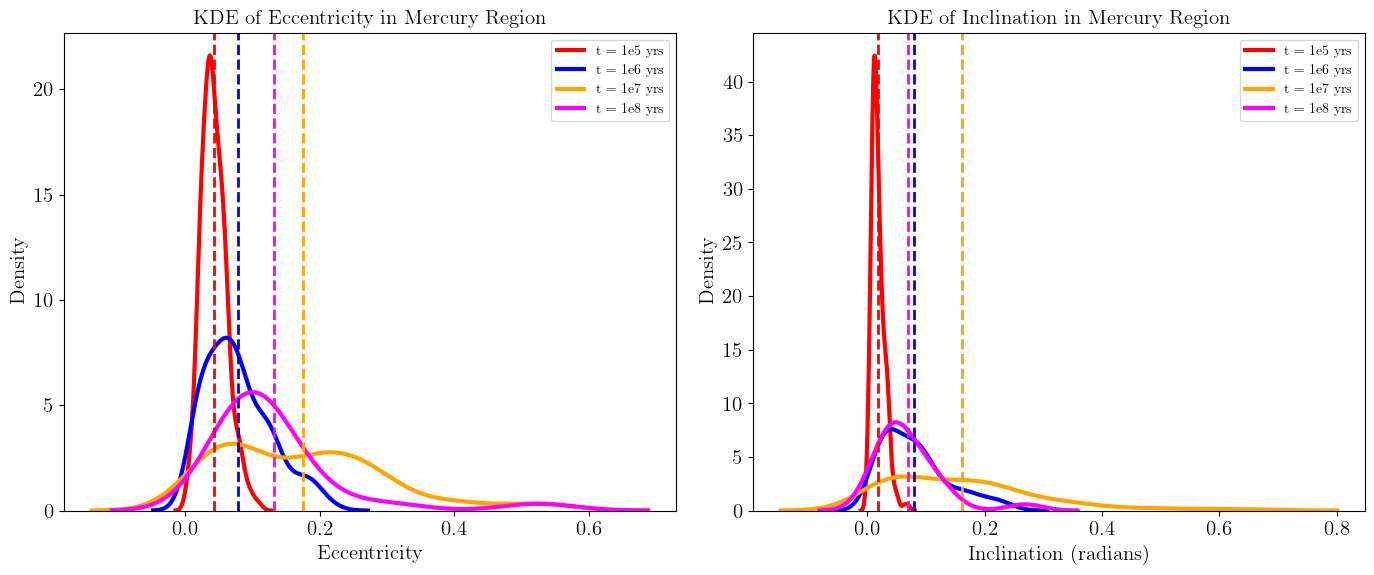

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

datasets = [
    ('t = 1e5 yrs', pp_merc_area_1, 'red'),
    ('t = 1e6 yrs', pp_merc_area_2, 'blue'),
    ('t = 1e7 yrs', pp_merc_area_3, 'orange'),
    ('t = 1e8 yrs', pp_merc_area_4, 'magenta')
]

# Print means
print("Mean eccentricity values:")
for label, pp, color in datasets:
    mean_ecc = pp['ecc'].mean()
    print(f"{label}: {mean_ecc:.4f}")

print("\nMean inclination values (radians):")
for label, pp, color in datasets:
    mean_inc = pp['inc'].mean()
    print(f"{label}: {mean_inc:.4f}")

# Plot Eccentricity KDE
for label, pp, color in datasets:
    sns.kdeplot(pp['ecc'], color=color, lw=3, label=label, ax=axes[0])

means_ecc = [(pp['ecc'].mean(), color) for _, pp, color in datasets]
for mean_val, color in means_ecc:
    axes[0].axvline(mean_val, color=color, linestyle='--', lw=2)

axes[0].set_xlabel("Eccentricity")
axes[0].set_ylabel("Density")
axes[0].set_title("KDE of Eccentricity in Mercury Region")
axes[0].legend()

# Plot Inclination KDE (radians)
for label, pp, color in datasets:
    sns.kdeplot(pp['inc'], color=color, lw=3, label=label, ax=axes[1])

means_inc = [(pp['inc'].mean(), color) for _, pp, color in datasets]
for mean_val, color in means_inc:
    axes[1].axvline(mean_val, color=color, linestyle='--', lw=2)

axes[1].set_xlabel("Inclination (radians)")
axes[1].set_ylabel("Density")
axes[1].set_title("KDE of Inclination in Mercury Region")
axes[1].legend()

plt.tight_layout()
plt.show()


In [170]:
#this is for head on impacts, for now
cstar = 1.8
rho1 = 1 #g/cm^3
def get_Q_star_zero(mt, mp):
    mtot = mt + mp
    Rc1 = ( (3 / (4 * np.pi * rho1)) * mtot)**(1/3)
    q_star = 0.8 * cstar * np.pi * rho1 * G * Rc1**2
    return q_star

#alpha is impact angle in radians
def get_Q_star(mt, mp, alpha, Q_star_zero): 
    gamma = mp/mt
    mu_alpha = (alpha * mt * mp)/(mt + alpha * mp)
    mu = (mt * mp)/(mt + mp)
    Q_star = (mu/mu_alpha)**(3/2) * (((1 + gamma)**2)/(4 * gamma)) * Q_star_zero
    return Q_star


def get_Q(mt, mp, vimp):
    mu = (mt * mp/(mt + mp))
    Q = (mu * vimp**2)/(2 * (mt + mp))
    return Q


def get_mlr(q, qstar, mt, mp):
    mtot = mt + mp
    ratio = q / qstar
    mlr = np.where(
        ratio < 1.8,
        mtot * (1 - 0.5 * ratio),
        mtot / 10 * ratio**(-3.2)
    )
    return mlr


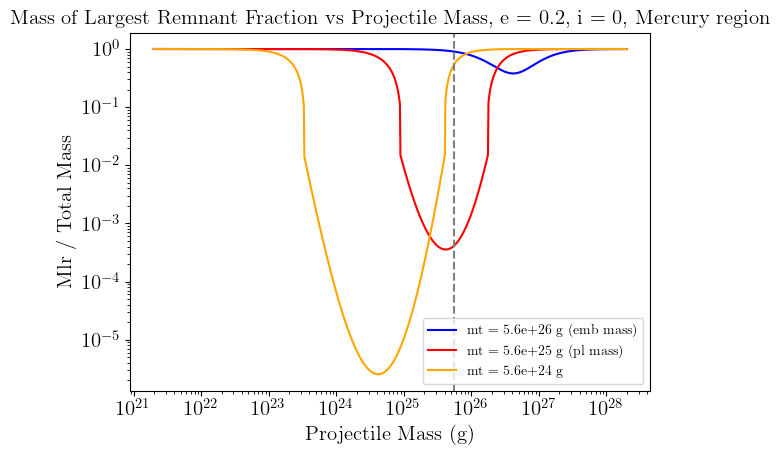

In [171]:
mlr1 = get_mlr(get_Q(mt1, mp, vi1), get_Q_star(mt1, mp, 1, get_Q_star_zero(mt1, mp)), mt1, mp)
mlr2 = get_mlr(get_Q(mt2, mp, vi1), get_Q_star(mt2, mp, 1, get_Q_star_zero(mt2, mp)), mt2, mp)
mlr3 = get_mlr(get_Q(mt3, mp, vi1), get_Q_star(mt3, mp, 1, get_Q_star_zero(mt3, mp)), mt3, mp)

plt.plot(mp, mlr1 / (mt1 + mp), label=f'mt = {mt1:.1e} g (emb mass)', color='blue')
plt.plot(mp, mlr2 / (mt2 + mp), label=f'mt = {mt2:.1e} g (pl mass)', color='red')
plt.plot(mp, mlr3 / (mt3 + mp), label=f'mt = {mt3:.1e} g', color='orange')
plt.axvline(2.8e-8 * M_sun, linestyle = '--', color = 'grey')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Projectile Mass (g)")
plt.ylabel("Mlr / Total Mass")
plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()


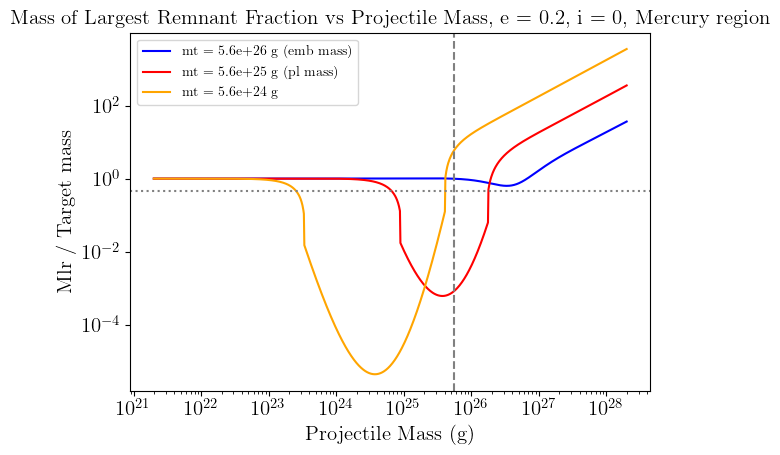

In [172]:
plt.plot(mp, mlr1 / (mt1), label=f'mt = {mt1:.1e} g (emb mass)', color='blue')
plt.plot(mp, mlr2 / (mt2), label=f'mt = {mt2:.1e} g (pl mass)', color='red')
plt.plot(mp, mlr3 / (mt3), label=f'mt = {mt3:.1e} g', color='orange')
plt.axvline(2.8e-8 * M_sun, linestyle = '--', color = 'grey')
plt.axhline(0.47, color = 'grey', linestyle = 'dotted')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Projectile Mass (g)")
plt.ylabel("Mlr / Target mass")
plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()


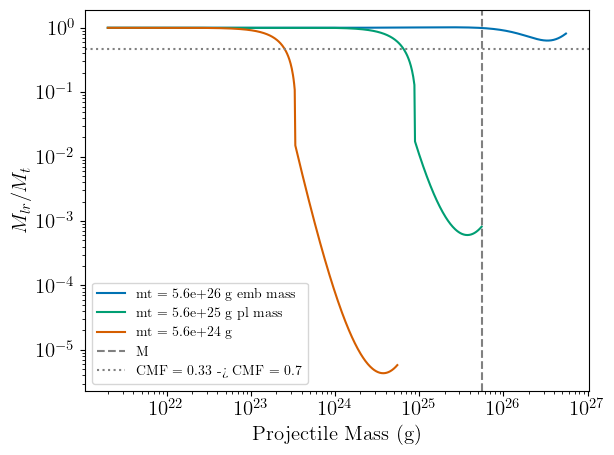

In [173]:
mlrs = [
    (mlr1, mt1, colors[0], 'emb mass'),
    (mlr2, mt2, colors[1], 'pl mass'),
    (mlr3, mt3, colors[2], '')
]

for mlr, mt, color, label in mlrs:
    ratio = mlr / mt
    mask = (mp < mt)
    plt.plot(mp[mask], ratio[mask], color=color, label=f'mt = {mt:.1e} g {label}')

plt.axvline(2.8e-8 * M_sun, ls='--', color='grey', label = 'M')
plt.axhline(0.47, ls='dotted', color='grey', label = 'CMF = 0.33 -> CMF = 0.7')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Projectile Mass (g)")
plt.ylabel(r"$M_{lr}/M_{t}$")
#plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()


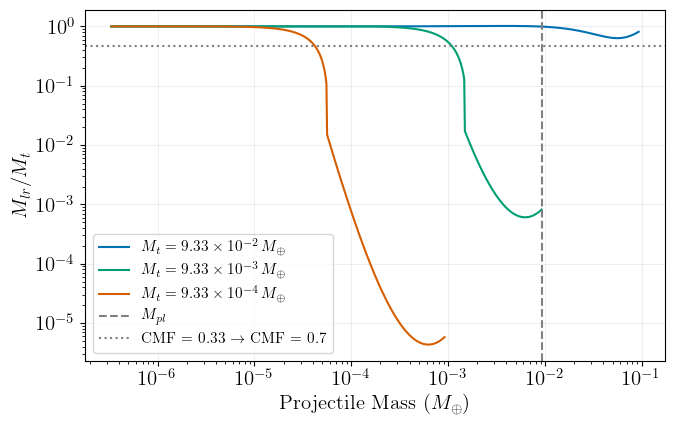

In [195]:
from astropy import units as u
from astropy.constants import M_sun, M_earth

plt.figure(figsize=(7,4.5))
mlrs = [
    (mlr1, mt1, colors[0], ''),
    (mlr2, mt2, colors[1], ''),
    (mlr3, mt3, colors[2], '')
]

for mlr, mt, color, label in mlrs:
    ratio = mlr / mt
    mask = (mp < mt)

    # Convert projectile masses to Earth masses for plotting
    mp_earth = (mp * u.g).to(u.M_earth).value
    mt_earth = (mt * u.g).to(u.M_earth).value

    # Format as base × 10^{exp}
    mt_str = f"{mt_earth:.2e}"
    base, exp = mt_str.split('e')
    exp = int(exp)
    mt_latex = rf"{float(base)} \times 10^{{{exp}}}"

    plt.plot(mp_earth[mask], ratio[mask],
             color=color,
             label=rf"$M_t = {mt_latex}\,M_\oplus$ {label}")

# Vertical line at 2.8e-8 M_sun, converted to Earth masses
pl_mass_earth = (2.8e-8 * M_sun).to(u.M_earth).value
pl_mass_str = f"{pl_mass_earth:.1e}"
pl_base, pl_exp = pl_mass_str.split('e')
pl_exp = int(pl_exp)
pl_latex = rf"{float(pl_base)} \times 10^{{{pl_exp}}}"

plt.axvline(pl_mass_earth,
            ls='--', color='grey',
            label=r"$M_{pl}$")

plt.axhline(0.47, ls='dotted', color='grey',
            label=r"CMF = 0.33 $\rightarrow$ CMF = 0.7")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Projectile Mass ($M_{\oplus}$)")
plt.ylabel(r"$M_{lr}/M_{t}$")
plt.legend(fontsize = 11)
plt.grid('True', alpha = 0.2)
plt.tight_layout()

plt.savefig("paper_plots/mlrmt_mp.pdf", dpi=300)

plt.show()


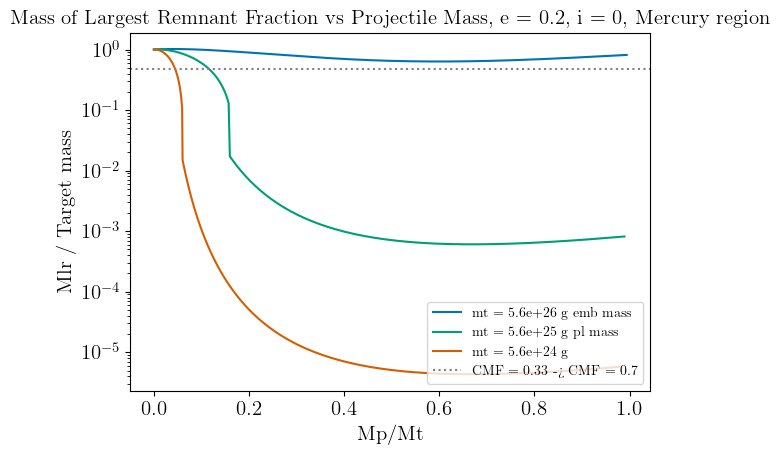

In [ ]:
for mlr, mt, color, label in mlrs:
    ratio = mlr / mt
    mask = (mp < mt)
    plt.plot(mp[mask]/mt, ratio[mask], color=color, label=f'mt = {mt:.1e} g {label}')


plt.axhline(0.47, ls='dotted', color='grey', label = 'CMF = 0.33 -> CMF = 0.7')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mp/Mt")
plt.ylabel("Mlr / Target mass")
plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()


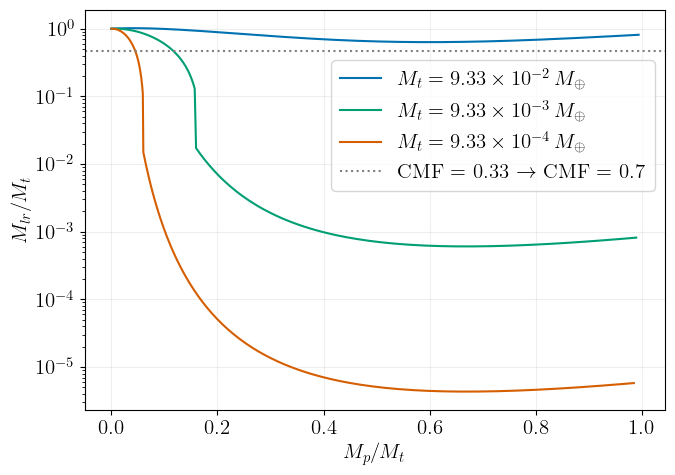

In [217]:
from astropy import units as u
from astropy.constants import M_earth
plt.figure(figsize=(7, 5))

for mlr, mt, color, label in mlrs:
    ratio = mlr / mt
    mask = (mp < mt)

    # Convert target mass from g to Earth masses
    mt_earth = (mt * u.g).to(u.M_earth).value

    # Format in LaTeX base × 10^{exp}
    mt_str = f"{mt_earth:.2e}"
    base, exp = mt_str.split('e')
    exp = int(exp)
    mt_latex = rf"{float(base)} \times 10^{{{exp}}}"

    plt.plot(mp[mask] / mt, ratio[mask],
             color=color,
             label=rf"$M_t = {mt_latex}\,M_\oplus$ {label}")

plt.axhline(0.47, ls='dotted', color='grey',
            label=r"CMF = 0.33 $\rightarrow$ CMF = 0.7")

#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$M_p/M_t$")
plt.ylabel(r"$M_{lr} / M_t$")
plt.grid('True', alpha = 0.2)
#plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend(fontsize=15, loc = 'upper right', bbox_to_anchor=(1, 0.9) )
plt.tight_layout()

plt.savefig("paper_plots/mlr-mt-gamma.pdf", dpi=300)

plt.show()


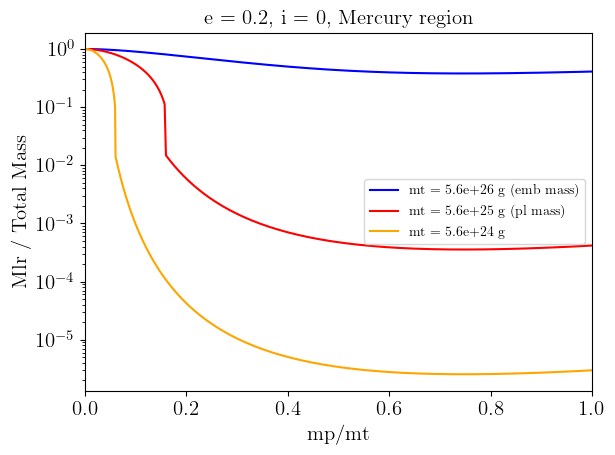

In [ ]:
plt.plot(mp/mt1, mlr1 / (mt1 + mp), label=f'mt = {mt1:.1e} g (emb mass)', color='blue')
plt.plot(mp/mt2, mlr2 / (mt2 + mp), label=f'mt = {mt2:.1e} g (pl mass)', color='red')
plt.plot(mp/mt3, mlr3 / (mt3 + mp), label=f'mt = {mt3:.1e} g', color='orange')
#plt.axvline(2.8e-8 * M_sun, linestyle = '--', color = 'grey')

plt.xlim(0,1)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel("mp/mt")
plt.ylabel("Mlr / Total Mass")
plt.title("e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()


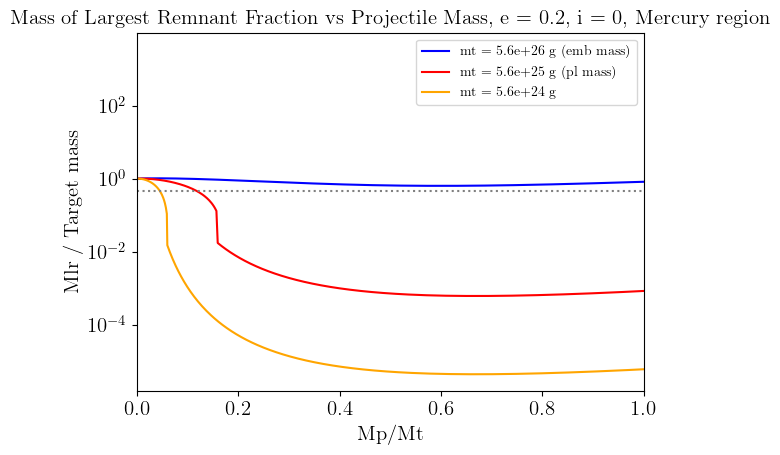

In [ ]:
plt.plot(mp/mt1, mlr1 / (mt1), label=f'mt = {mt1:.1e} g (emb mass)', color='blue')
plt.plot(mp/mt2, mlr2 / (mt2), label=f'mt = {mt2:.1e} g (pl mass)', color='red')
plt.plot(mp/mt3, mlr3 / (mt3), label=f'mt = {mt3:.1e} g', color='orange')
plt.axhline(0.47, color = 'grey', linestyle = 'dotted')

plt.xlim(0,1)
plt.yscale('log')
plt.xlabel("Mp/Mt")
plt.ylabel("Mlr / Target mass")
plt.title("Mass of Largest Remnant Fraction vs Projectile Mass, e = 0.2, i = 0, Mercury region")
plt.legend()
plt.tight_layout()
plt.show()
